<h1><center>9.SEGMENTATION USING GRAPH-CUT, THRESHOLDING, K-MEANS CLUSTERING, MEAN SHIFTING, REGION GROWING</center></h1>

In [2]:
import cv2
import numpy as np
import matplotlib.pyplot as plt

<h2>1)Segmentation Using Graph Cut Method</h2>

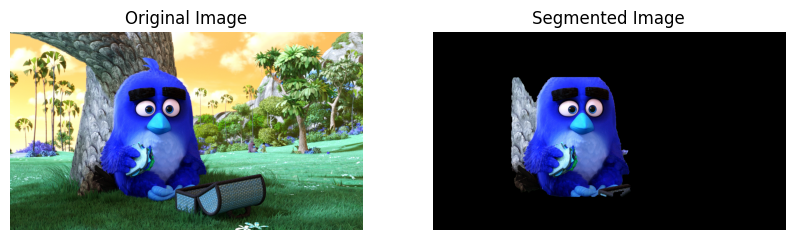

In [ ]:
image = cv2.imread(r"birds.jpg") #Replace with your image path

#create an Initial Mask
mask = np.zeros(image.shape[:2], np.uint8)

#Define a rough bounding Box around the bird
rect = (850, 500, 1300, 1300)

#Backgroud and Foreground model for Grabcut
bgd_model = np.zeros((1,65),np.float64)
fgd_model = np.zeros((1,65),np.float64)

#Run GrabCut Algorithm
cv2.grabCut(image,mask,rect,bgd_model,fgd_model,10,cv2.GC_INIT_WITH_RECT)

#Convert mask to binary:
binary_mask = np.where((mask==2)|(mask==0),0,1).astype('uint8')

#Extract Segmented bird
Segmented = image * binary_mask[:,:,np.newaxis]

#**post-processing to clean up the mask**
kernel = np.ones((5,5),np.uint8)

#Apply morphological operations to remove small noise
binary_mask = cv2.morphologyEx(binary_mask,cv2.MORPH_OPEN,kernel,iterations=2)
binary_mask = cv2.morphologyEx(binary_mask,cv2.MORPH_CLOSE,kernel,iterations=2)

#Find contours and Keep only the largest one
contours,_ = cv2.findContours(binary_mask,cv2.RETR_EXTERNAL,cv2.CHAIN_APPROX_SIMPLE)

if contours:
    max_contour = max(contours,key= cv2.contourArea)
    mask_cleaned = np.zeros_like(binary_mask)
    cv2.drawContours(mask_cleaned,[max_contour],-1,1,thickness=cv2.FILLED)

    #Apply cleaned mask to the Image
    segmented = image * mask_cleaned[:,:,np.newaxis]


# Display the images
plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.imshow(image)
plt.title("Original Image")
plt.axis("off")

plt.subplot(1, 2, 2)
plt.imshow(segmented)
plt.title("Segmented Image")
plt.axis("off")

plt.show()

<h2>2)Segmention Using Threshold Method(Manual)</h2>

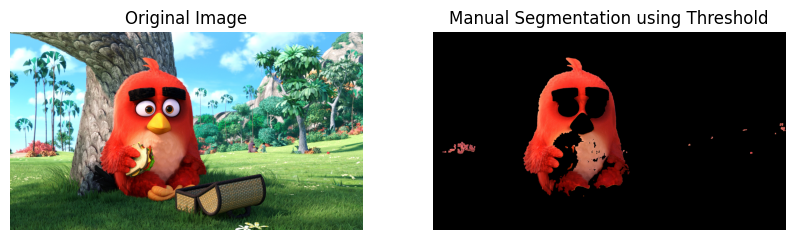

In [ ]:
image = cv2.imread(r"birds.jpg")  #Replace with your image path
image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

# Convert to HSV color space
hsv = cv2.cvtColor(image, cv2.COLOR_RGB2HSV)

# Define refined range for red color
lower_red1 = [0, 120, 80]  
upper_red1 = [10, 255, 255]

lower_red2 = [160, 120, 80]  
upper_red2 = [180, 255, 255]

# Get image dimensions
h, w, _ = hsv.shape

# Create a blank mask (all black)
mask = np.zeros((h, w), dtype=np.uint8)

# Manually apply thresholding
for y in range(h):
    for x in range(w):
        h_val, s_val, v_val = hsv[y, x]

        # Check if the pixel falls within either red range
        in_range1 = lower_red1[0] <= h_val <= upper_red1[0] and lower_red1[1] <= s_val <= upper_red1[1] and lower_red1[2] <= v_val <= upper_red1[2]
        in_range2 = lower_red2[0] <= h_val <= upper_red2[0] and lower_red2[1] <= s_val <= upper_red2[1] and lower_red2[2] <= v_val <= upper_red2[2]

        if in_range1 or in_range2:
            mask[y, x] = 255  # Mark as foreground (white)

# Manually perform morphological operations (opening + dilation)
kernel_size = 10  # Kernel size
kernel = np.ones((kernel_size, kernel_size), dtype=np.uint8)

# Erosion (to remove noise)
eroded_mask = np.zeros_like(mask)
for y in range(h - kernel_size):
    for x in range(w - kernel_size):
        if np.all(mask[y:y + kernel_size, x:x + kernel_size] == 255):
            eroded_mask[y + kernel_size // 2, x + kernel_size // 2] = 255

# Dilation (to fill small holes)
dilated_mask = np.zeros_like(eroded_mask)
for y in range(h - kernel_size):
    for x in range(w - kernel_size):
        if np.any(eroded_mask[y:y + kernel_size, x:x + kernel_size] == 255):
            dilated_mask[y + kernel_size // 2, x + kernel_size // 2] = 255

# Apply the mask to the original image
segmented = np.zeros_like(image)
for y in range(h):
    for x in range(w):
        if dilated_mask[y, x] == 255:
            segmented[y, x] = image[y, x]

# Display results
plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.imshow(image)
plt.axis('off')
plt.title("Original Image")

plt.subplot(1, 2, 2)
plt.imshow(segmented)
plt.axis('off')
plt.title("Manual Segmentation using Threshold")

plt.show()

<h2>3)Segementation Using Region Growing(Manual)</h2>

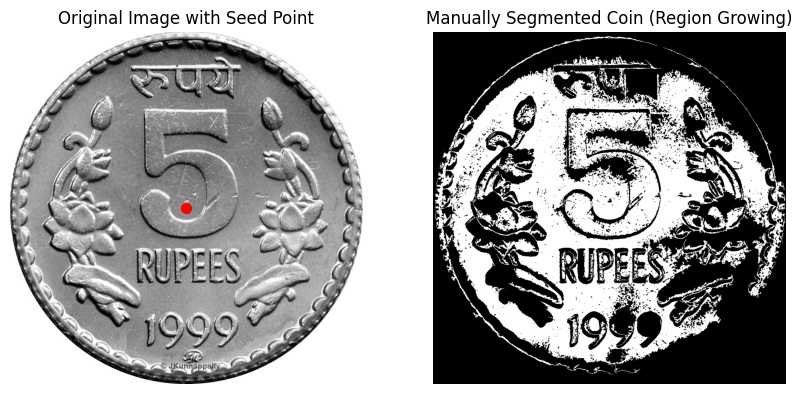

In [ ]:
def manual_region_growing(image, seed, threshold=25):
    h, w = image.shape
    segmented = [[0] * w for _ in range(h)]  # Create blank segmented image
    visited = [[0] * w for _ in range(h)]  # Keep track of visited pixels

    seed_x, seed_y = seed
    seed_value = image[seed_y][seed_x]  # Seed pixel intensity

    stack = [(seed_x, seed_y)]  # Stack for DFS

    while stack:
        x, y = stack.pop()
        if visited[y][x]:  
            continue

        visited[y][x] = 1  # Mark pixel as visited

        # Check if pixel is within threshold
        if abs(int(image[y][x]) - int(seed_value)) < threshold:
            segmented[y][x] = 255  # Set segmented pixel to white (255)

            # 8-Connected Neighbors
            for dx, dy in [(-1, 0), (1, 0), (0, -1), (0, 1), 
                           (-1, -1), (1, 1), (-1, 1), (1, -1)]:
                nx, ny = x + dx, y + dy
                if 0 <= nx < w and 0 <= ny < h and not visited[ny][nx]:  
                    stack.append((nx, ny))  # Add neighbor to stack

    return segmented

# Load image in grayscale
image = cv2.imread(r"coin.jpg", cv2.IMREAD_GRAYSCALE)#Replace with your image path

# Define seed point (adjust manually)
seed_point = (600, 600)  

# Apply manual region growing
segmented_image = manual_region_growing(image, seed_point, threshold=25)

# Convert list to NumPy array
segmented_image = np.array(segmented_image, dtype=np.uint8)

# Display results
plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.imshow(image, cmap='gray')
plt.scatter(*seed_point, color='red', marker='o', s=50)
plt.title("Original Image with Seed Point")
plt.axis('off')

plt.subplot(1, 2, 2)
plt.imshow(segmented_image, cmap='gray')
plt.title("Manually Segmented Coin (Region Growing)")
plt.axis('off')
plt.show()

<h2>4)Segmentation Using Mean Shift</h2>

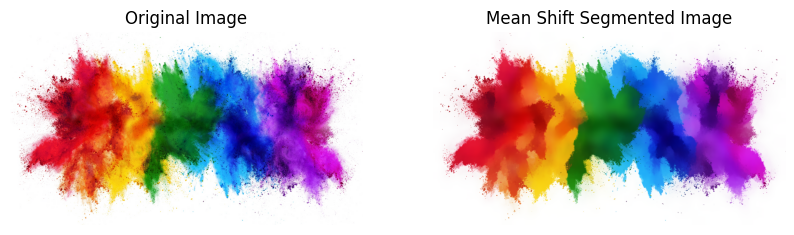

In [ ]:
image = cv2.imread(r"color.jpeg") #Replace with your image path
image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

# Apply OpenCV Mean Shift (FAST!)
segmented_image = cv2.pyrMeanShiftFiltering(image, sp=30, sr=60)

# Show images
plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.imshow(image)
plt.axis('off')
plt.title("Original Image")

plt.subplot(1, 2, 2)
plt.imshow(segmented_image)
plt.axis('off')
plt.title("Mean Shift Segmented Image")

plt.show()

<h2>5)Segmentation Using K-Means Clustering</h2>

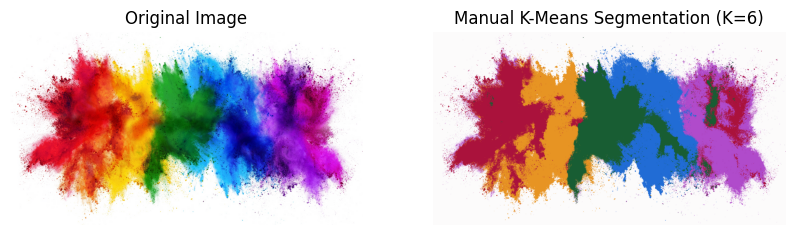

In [ ]:
image = cv2.imread(r'color.jpeg') #Replace with your image path 
image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

# Flatten the image into (num_pixels, 3) shape
h, w, c = image.shape
pixels = image.reshape((-1, 3)).astype(np.float32)

# Define number of clusters (K)
K = 6  # Adjust based on desired segmentation

# Initialize centroids randomly from the dataset
random.seed(42)
centroids = pixels[random.sample(range(len(pixels)), K)]

# K-Means Clustering (Manual)
max_iter = 10  # Set max iterations for convergence
for _ in range(max_iter):
    # Step 1: Assign each pixel to the nearest centroid
    clusters = [[] for _ in range(K)]
    
    for pixel in pixels:
        distances = [np.linalg.norm(pixel - centroid) for centroid in centroids]
        cluster_idx = np.argmin(distances)
        clusters[cluster_idx].append(pixel)
    
    # Step 2: Recalculate centroids as mean of assigned pixels
    new_centroids = []
    for cluster in clusters:
        if cluster:
            new_centroids.append(np.mean(cluster, axis=0))
        else:
            new_centroids.append(random.choice(pixels))  # Avoid empty cluster

    new_centroids = np.array(new_centroids)
    
    # Step 3: Check for convergence (if centroids don't change)
    if np.allclose(centroids, new_centroids, atol=1e-2):
        break
    
    centroids = new_centroids  # Update centroids

# Step 4: Assign final cluster colors
segmented_pixels = np.zeros_like(pixels)
for i, pixel in enumerate(pixels):
    distances = [np.linalg.norm(pixel - centroid) for centroid in centroids]
    cluster_idx = np.argmin(distances)
    segmented_pixels[i] = centroids[cluster_idx]

# Reshape segmented image
segmented_image = segmented_pixels.reshape((h, w, c)).astype(np.uint8)

# Display Results
plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.imshow(image)
plt.axis('off')
plt.title("Original Image")

plt.subplot(1, 2, 2)
plt.imshow(segmented_image)
plt.axis('off')
plt.title(f"Manual K-Means Segmentation (K={K})")

plt.show()